In [79]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import requests
from collections import defaultdict
import networkx as nx
import scipy.stats as stats

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, K2Score

In [80]:
dataset_path = "recipeNLG.csv"
df = pd.read_csv(dataset_path, index_col = 0)

# TESTING PURPOSES : Cull 99% of the data randomly to ensure faster data processing
# df = df.sample(n = int(len(df) * 0.01), random_state = 42).reset_index(drop = True)

df = df.drop(columns=['link', 'source', 'directions'], errors='ignore')

df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Show dataset sample
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231142 entries, 0 to 2231141
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   title        object
 1   ingredients  object
 2   NER          object
dtypes: object(3)
memory usage: 68.1+ MB


In [81]:
# We need this list of measurement units for filtering (unfortunate really)
MEASUREMENT_UNITS = [
    'tsp', 'tbsp', 'c', 'cup', 'cups', 'ml', 'l', 'liters', 'liter', 'fl oz', 'fluid ounce',
    'oz', 'ounce', 'ounces', 'g', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'lb', 'pound', 'pounds',
    'piece', 'clove', 'slice', 'dash', 'pinch', 'quart', 'pint'
]
unit_pattern = re.compile(r'\b(?:' + '|'.join(MEASUREMENT_UNITS) + r')\b', re.IGNORECASE)
number_pattern = re.compile(r'(\d+(/\d+)?\s*)')

In [82]:
def extract_ingredient_data(ingredient):
    # Edge case / error handling
    if not isinstance(ingredient, str) or ingredient.strip() == "":
        return None, ""

    ingredient_lower = ingredient.lower().strip()

    amount_match = number_pattern.search(ingredient_lower)
    amount = amount_match.group(0).strip() if amount_match else "unknown"

    unit_match = unit_pattern.search(ingredient_lower)
    unit = unit_match.group(0) if unit_match else "unknown"

    cleaned_ingredient = number_pattern.sub('', ingredient_lower)
    cleaned_ingredient = unit_pattern.sub('', cleaned_ingredient)
    cleaned_ingredient = re.sub(r'[^\w\s]', '', cleaned_ingredient)
    cleaned_ingredient = cleaned_ingredient.strip()

    return cleaned_ingredient, f"{amount} {unit}"

In [83]:
def process_ingredients(ingredient_list):
    # Error case / edge case handling
    if not isinstance(ingredient_list, list) or len(ingredient_list) == 0:
        return [], []

    extracted_data = [extract_ingredient_data(ingredient) for ingredient in ingredient_list]
    cleaned, ner = zip(*extracted_data) if extracted_data else ([], [])

    cleaned = [c if c is not None else "" for c in cleaned]
    ner = [n if n is not None else "" for n in ner]

    return list(cleaned), list(ner)

In [84]:
df[['cleaned_ingredients', 'NER']] = df['ingredients'].apply(lambda lst: pd.Series(process_ingredients(lst)))
df['NER'] = df['NER'].apply(lambda x: x if isinstance(x, list) else [])
df = df[df['NER'].apply(lambda ner_list: all("unknown" not in ner for ner in ner_list))]

df = df.reset_index(drop=True)
df = df.drop(columns = ['ingredients'], errors = 'ignore')
df = df.rename(columns={'NER': 'measurements', 'cleaned_ingredients' : 'ingredients'})
df['num_ingredients'] = df['ingredients'].apply(len)

In [85]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170495 entries, 0 to 170494
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            170495 non-null  object
 1   measurements     170495 non-null  object
 2   ingredients      170495 non-null  object
 3   num_ingredients  170495 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


In [86]:
# CPT
ingredient_pairs = Counter()
for ingredients in df['ingredients']:  
    for pair in combinations(set(ingredients), 2): 
        ingredient_pairs[pair] += 1

total_pairs = sum(ingredient_pairs.values())
ingredient_co_occurrence_probs = {pair: count / total_pairs for pair, count in ingredient_pairs.items()}

top_co_occurrences = sorted(ingredient_co_occurrence_probs.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Ingredient Pair Probabilities:")
for pair, prob in top_co_occurrences:
    print(f"{pair}: {prob:.4f}")


Top 10 Ingredient Pair Probabilities:
('sugar', 'salt'): 0.0045
('sugar', 'vanilla'): 0.0031
('flour', 'salt'): 0.0030
('sugar', 'flour'): 0.0026
('pepper', 'salt'): 0.0023
('sugar', 'milk'): 0.0021
('water', 'salt'): 0.0021
('sugar', 'butter'): 0.0020
('salt', 'milk'): 0.0020
('sugar', 'water'): 0.0017


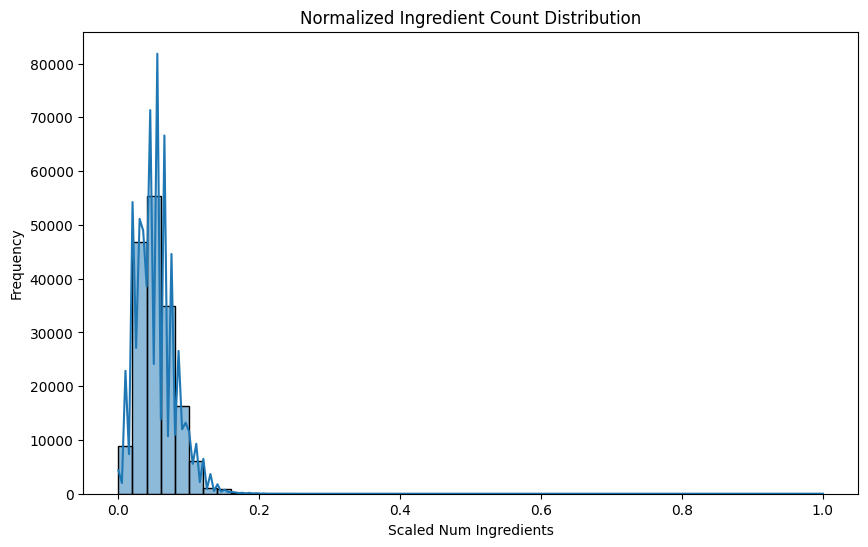

In [87]:
# Scaling to help training
scaler = MinMaxScaler()
df['num_ingredients_scaled'] = scaler.fit_transform(df[['num_ingredients']])

plt.figure(figsize=(10,6))
sns.histplot(df['num_ingredients_scaled'], bins=50, kde=True)
plt.title('Normalized Ingredient Count Distribution')
plt.xlabel('Scaled Num Ingredients')
plt.ylabel('Frequency')
plt.show()

In [88]:
# LOADING USDA FILES HERE
branded_food = pd.read_csv("branded_food.csv")  
food_nutrient = pd.read_csv("food_nutrient.csv")  
nutrient_info = pd.read_csv("nutrient.csv")  

branded_food = branded_food[['fdc_id', 'ingredients', 'serving_size', 'serving_size_unit', 'gtin_upc']]
food_nutrient = food_nutrient[['fdc_id', 'nutrient_id', 'amount']]
nutrient_info = nutrient_info[['id', 'name', 'unit_name']]

food_nutrient = food_nutrient.merge(nutrient_info, left_on='nutrient_id', right_on='id', how='left')
needed_nutrients = ["Energy", "Protein", "Total lipid (fat)", "Carbohydrate, by difference"]
food_nutrient = food_nutrient[food_nutrient['name'].isin(needed_nutrients)]

# Handle duplicate id values
food_nutrient = food_nutrient.groupby(['fdc_id', 'name'], as_index=False).agg({'amount': 'mean'})
food_nutrient_pivot = food_nutrient.pivot(index='fdc_id', columns='name', values='amount').reset_index()
food_nutrient_pivot.columns.name = None  # Remove hierarchical index name
food_nutrient_pivot = food_nutrient_pivot.rename_axis(None, axis=1)  # Fully reset column index

# Simplifying names easier syntaxing
food_nutrient_pivot = food_nutrient_pivot.rename(columns={
    "Energy": "calories",
    "Protein": "protein",
    "Total lipid (fat)": "fat",
    "Carbohydrate, by difference": "carbohydrates"
})
food_df = food_nutrient_pivot.merge(branded_food, on="fdc_id", how="left")

# Culling data set for testing purposes
# food_df = food_df.sample(n = int(len(df) * 0.0001), random_state = 42).reset_index(drop = True)

# Display sample of processed data
print(food_df.head())
print(food_df.shape)


C:\Users\david\AppData\Local\Temp\ipykernel_18140\1255449476.py:2: DtypeWarning: Columns (2,3,4,6,9,12,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  branded_food = pd.read_csv("branded_food.csv")


   fdc_id  carbohydrates  calories  protein    fat  \
0  344604           4.07      24.0     0.81   0.41   
1  344605           4.07      24.0     0.81   0.41   
2  344606           0.00       NaN    23.21   2.68   
3  344607           0.00       NaN    23.21   2.68   
4  344608           0.00       NaN    18.75  15.18   

                                         ingredients  serving_size  \
0  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
1  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
2                    White Turkey, Natural Flavoring         112.0   
3                   Turkey Breast, Natural Flavoring         112.0   
4                         Turkey, natural Flavoring.         112.0   

  serving_size_unit        gtin_upc  
0                 g  00072940755050  
1                 g  00072940755043  
2                 g  00642205534517  
3                 g  00642205510276  
4                 g  00642205534500  
(1874041, 9)


In [89]:
# NEEDED PREPROCESSING FOR FASTER PROCESSING WAY TOO SLOW
usda_ingredient_map = defaultdict(list)
for idx, row in food_df.iterrows():
    for ingredient in str(row['ingredients']).split(', '): 
        usda_ingredient_map[ingredient.lower()].append(row)

def match_ingredient_to_usda(ingredient_list):
    matched_nutrition = []
    # total = 0 #Used previously to track progress

    for ingredient in ingredient_list:
        # total += 1 # Progress tracker
        matches = usda_ingredient_map.get(ingredient.lower(), None)
        if matches:
            matched_nutrition.append(matches[0]) 
        else:
            # ERROR HANDLING
            matched_nutrition.append(None)
    return matched_nutrition

df['matched_nutrition'] = df['ingredients'].apply(match_ingredient_to_usda)
df['matched_nutrition'] = df['matched_nutrition'].apply( lambda x: [dict(item) if isinstance(item, pd.Series) else None for item in x] )

In [90]:
def compute_recipe_nutrition(matched_nutrition):
    if not matched_nutrition or all(item is None for item in matched_nutrition):  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})
    valid_nutrition = [item for item in matched_nutrition if item and isinstance(item, dict)]

    if not valid_nutrition:  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})

    valid_nutrition = [
        {k: item.get(k, 0) for k in ['calories', 'protein', 'fat', 'carbohydrates']}
        for item in valid_nutrition
    ]

    return pd.Series(pd.DataFrame(valid_nutrition).sum())

df[['calories', 'protein', 'fat', 'carbohydrates']] = df['matched_nutrition'].apply(compute_recipe_nutrition)

df = df.dropna()

print(df.head()) # Checking


                              title  \
0               No-Bake Nut Cookies   
1                       Creamy Corn   
2             Double Cherry Delight   
3  Eggless Milkless Applesauce Cake   
4                        Easy Fudge   

                                       measurements  \
0         [1 c, 1/2 c, 1/2 tsp, 1/2 c, 2 tbsp, 3 c]   
1    [2 oz, 1 oz, 1/3 c, 1/2 tsp, 1/2 tsp, 1/4 tsp]   
2            [1 oz, 1/2 c, 1 oz, 2 c, 1/8 tsp, 1 c]   
3  [3/4 c, 1/2 c, 1 c, 3 tsp, 1 tsp, 2 c, 1 c, 1 c]   
4                    [1 oz, 1 oz, 1 oz, 1 c, 1 tsp]   

                                         ingredients  num_ingredients  \
0  [firmly packed brown sugar, evaporated milk, v...                6   
1  [pkg frozen corn, pkg cream cheese cubed, butt...                6   
2  [can dark sweet pitted cherries, ginger ale, p...                6   
3  [sugar, shortening, applesauce, level  soda, e...                8   
4  [can sweetened condensed milk, pkg semisweet c...                5

       num_ingredients  num_ingredients_scaled       calories        protein  \
count    149338.000000           149338.000000  149338.000000  149338.000000   
mean          6.166086                0.056153     363.162966      26.786618   
std           2.473979                0.026891     475.309884      19.502371   
min           1.000000                0.000000       0.000000       0.000000   
25%           4.000000                0.032609       0.000000      12.190000   
50%           6.000000                0.054348     288.000000      23.270000   
75%           8.000000                0.076087     539.000000      37.830000   
max          93.000000                1.000000   16203.000000     912.050000   

                 fat  carbohydrates  
count  149338.000000  149338.000000  
mean       51.064182     166.690243  
std        39.985468     126.359195  
min         0.000000       0.000000  
25%        23.100000      71.900000  
50%        43.900000     139.785000  
75%        72

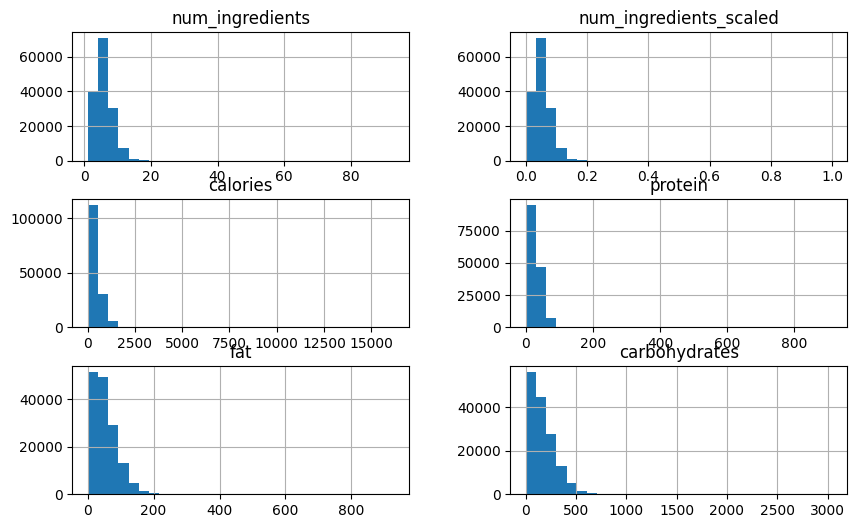

In [91]:
print(df.describe())

df.hist(figsize= (10, 6), bins = 30)
plt.show()

In [92]:
bn_data = df[['title', 'num_ingredients', 'calories', 'protein', 'fat', 'carbohydrates']].copy()

calorie_edges = [-np.inf, 250, 500, 750, 1000, np.inf]
protein_edges = [-np.inf, 10, 20, 50, np.inf]
fat_edges = [-np.inf, 25, 50, 75, np.inf]
carb_edges = [-np.inf, 25, 50, 75, np.inf]

# Print the bin edges for debugging/verification
print("Calorie bin edges:", calorie_edges)
print("Protein bin edges:", protein_edges)
print("Fat bin edges:", fat_edges)
print("Carb bin edges:", carb_edges)


Calorie bin edges: [-inf, 250, 500, 750, 1000, inf]
Protein bin edges: [-inf, 10, 20, 50, inf]
Fat bin edges: [-inf, 25, 50, 75, inf]
Carb bin edges: [-inf, 25, 50, 75, inf]


In [93]:
categories = ["calorie_category", "protein_category", "fat_category", "carb_category"]
columns = ["calories", "protein", "fat", "carbohydrates"]
edge_list = [calorie_edges, protein_edges, fat_edges, carb_edges]
units = ["kcal", "g", "g", "g"]

for category, column, edges, unit in zip(categories, columns, edge_list, units):
    curr_labels = []

    for i in range(len(edges) - 1):
        lower_bound = edges[i] if edges[i] != -np.inf else 0
        upper_bound = edges[i+1] if edges[i+1] != np.inf else None
        
        if upper_bound != None:
            curr_labels += [f"{lower_bound}-{upper_bound} {unit}"]
        else:
            curr_labels += [f"{lower_bound}+ {unit}"]

    bn_data[category] = pd.cut(bn_data[column], bins = edges, labels = curr_labels)

In [94]:
print("\nEnsuring all bins have been categorized properly")
for category in categories:
    print(f"\n{category}")
    print(bn_data[category].cat.categories)

print("\nShowing how data is categorized now:")
print(bn_data[['title', 'calorie_category', 'protein_category', 'fat_category', 'carb_category']].head())

print("\nbn_data shape")
print(bn_data.shape)


Ensuring all bins have been categorized properly

calorie_category
Index(['0-250 kcal', '250-500 kcal', '500-750 kcal', '750-1000 kcal',
       '1000+ kcal'],
      dtype='object')

protein_category
Index(['0-10 g', '10-20 g', '20-50 g', '50+ g'], dtype='object')

fat_category
Index(['0-25 g', '25-50 g', '50-75 g', '75+ g'], dtype='object')

carb_category
Index(['0-25 g', '25-50 g', '50-75 g', '75+ g'], dtype='object')

Showing how data is categorized now:
                              title calorie_category protein_category  \
0               No-Bake Nut Cookies       0-250 kcal          20-50 g   
1                       Creamy Corn       0-250 kcal          20-50 g   
2             Double Cherry Delight       0-250 kcal           0-10 g   
3  Eggless Milkless Applesauce Cake       1000+ kcal          20-50 g   
4                        Easy Fudge       0-250 kcal          10-20 g   

  fat_category carb_category  
0       0-25 g         75+ g  
1      25-50 g         75+ g  
2     

In [95]:
# Now drop the original continuous variables
bn_data = bn_data.drop(columns=['title', 'calories', 'protein', 'fat', 'carbohydrates'])

# Print out the head and distributions for verification
print("\nFinal data sample:")
print(bn_data.head())

print("\nCalorie Category Distribution:")
print(bn_data["calorie_category"].value_counts())
print("\nProtein Category Distribution:")
print(bn_data["protein_category"].value_counts())
print("\nFat Category Distribution:")
print(bn_data["fat_category"].value_counts())
print("\nCarb Category Distribution:")
print(bn_data["carb_category"].value_counts())


Final data sample:
   num_ingredients calorie_category protein_category fat_category  \
0                6       0-250 kcal          20-50 g       0-25 g   
1                6       0-250 kcal          20-50 g      25-50 g   
2                6       0-250 kcal           0-10 g       0-25 g   
3                8       1000+ kcal          20-50 g        75+ g   
4                5       0-250 kcal          10-20 g       0-25 g   

  carb_category  
0         75+ g  
1         75+ g  
2       25-50 g  
3         75+ g  
4       50-75 g  

Calorie Category Distribution:
calorie_category
0-250 kcal       69995
250-500 kcal     37349
500-750 kcal     20212
750-1000 kcal    12964
1000+ kcal        8818
Name: count, dtype: int64

Protein Category Distribution:
protein_category
20-50 g    67464
10-20 g    32986
0-10 g     31141
50+ g      17747
Name: count, dtype: int64

Fat Category Distribution:
fat_category
25-50 g    44372
0-25 g     39637
75+ g      34394
50-75 g    30935
Name: count, dt

In [96]:
print("Calorie Category Distribution:")
print(bn_data["calorie_category"].value_counts())

print("\nProtein Category Distribution:")
print(bn_data["protein_category"].value_counts())

print("\nFat Category Distribution:")
print(bn_data["fat_category"].value_counts())

print("\nCarb Category Distribution:")
print(bn_data["carb_category"].value_counts())

print("Missing Values in Categorical Data:")
print(bn_data.isnull().sum())

print("Unique Values in carb_category:", bn_data["carb_category"].unique())

Calorie Category Distribution:
calorie_category
0-250 kcal       69995
250-500 kcal     37349
500-750 kcal     20212
750-1000 kcal    12964
1000+ kcal        8818
Name: count, dtype: int64

Protein Category Distribution:
protein_category
20-50 g    67464
10-20 g    32986
0-10 g     31141
50+ g      17747
Name: count, dtype: int64

Fat Category Distribution:
fat_category
25-50 g    44372
0-25 g     39637
75+ g      34394
50-75 g    30935
Name: count, dtype: int64

Carb Category Distribution:
carb_category
75+ g      106591
50-75 g     19433
0-25 g      13426
25-50 g      9888
Name: count, dtype: int64
Missing Values in Categorical Data:
num_ingredients     0
calorie_category    0
protein_category    0
fat_category        0
carb_category       0
dtype: int64
Unique Values in carb_category: ['75+ g', '25-50 g', '50-75 g', '0-25 g']
Categories (4, object): ['0-25 g' < '25-50 g' < '50-75 g' < '75+ g']


In [97]:
# Must explain in Readme file why it was necessary
hc = HillClimbSearch(bn_data)
best_model = hc.estimate(scoring_method=K2Score(bn_data))
bayesian_model = BayesianNetwork(best_model.edges())
bayesian_model.fit(bn_data, estimator=MaximumLikelihoodEstimator)


  0%|          | 12/1000000 [00:00<6:22:05, 43.62it/s]


In [98]:
print("Learned Bayesian Network Structure:")
print(bayesian_model.edges())

Learned Bayesian Network Structure:
[('num_ingredients', 'calorie_category'), ('num_ingredients', 'fat_category'), ('num_ingredients', 'protein_category'), ('num_ingredients', 'carb_category'), ('fat_category', 'calorie_category'), ('protein_category', 'fat_category'), ('protein_category', 'calorie_category'), ('carb_category', 'protein_category'), ('carb_category', 'calorie_category'), ('carb_category', 'fat_category')]


In [105]:
inference = VariableElimination(bayesian_model)

if all(var in bayesian_model.nodes() for var in ["protein_category", "fat_category", "carb_category", "calorie_category"]):
    query_result_multi = inference.query(variables=["protein_category", "fat_category", "carb_category"], evidence={"calorie_category": "0-250 kcal"})
    max_index = query_result_multi.values.argmax()
    max_prob = query_result_multi.values.max()

    best_protein = query_result_multi.state_names["protein_category"][max_index // (len(query_result_multi.state_names["fat_category"]) * len(query_result_multi.state_names["carb_category"]))]
    best_fat = query_result_multi.state_names["fat_category"][(max_index // len(query_result_multi.state_names["carb_category"])) % len(query_result_multi.state_names["fat_category"])]
    best_carb = query_result_multi.state_names["carb_category"][max_index % len(query_result_multi.state_names["carb_category"])]

    print("\nMost probable (Protein, Fat, Carb) recommendation given query:")
    print(f"Protein = {best_protein}, Fat = {best_fat}, Carbs = {best_carb} (P={max_prob:.4f})")

    # Full marginal probability distribution
    print("\nP(proteins, fats, carbs | calories = query):")
    print(query_result_multi)



Most probable (Protein, Fat, Carb) recommendation given query:
Protein = 10-20 g, Fat = 25-50 g, Carbs = 75+ g (P=0.1290)

P(proteins, fats, carbs | calories = query):
+---------------------------+-----------------------+------------------------+----------------------------------------------------+
| protein_category          | fat_category          | carb_category          |   phi(protein_category,fat_category,carb_category) |
+===========================+=======================+========================+====================================================+
| protein_category(0-10 g)  | fat_category(0-25 g)  | carb_category(0-25 g)  |                                             0.1069 |
+---------------------------+-----------------------+------------------------+----------------------------------------------------+
| protein_category(0-10 g)  | fat_category(0-25 g)  | carb_category(25-50 g) |                                             0.0360 |
+---------------------------+----------

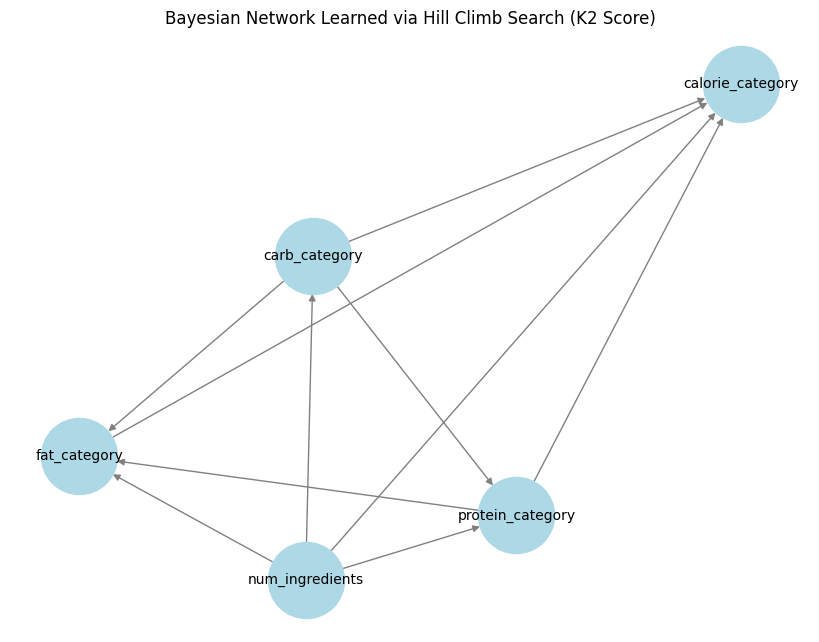

Learned Bayesian Network Edges:
num_ingredients to calorie_category
num_ingredients to fat_category
num_ingredients to protein_category
num_ingredients to carb_category
fat_category to calorie_category
protein_category to fat_category
protein_category to calorie_category
carb_category to protein_category
carb_category to calorie_category
carb_category to fat_category


In [100]:
# Bayesian Neywork: Hill Climb Search
plt.figure(figsize=(8, 6))
G = nx.DiGraph(bayesian_model.edges())
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", 
        node_size=3000, font_size=10, arrows=True)

plt.title("Bayesian Network Learned via Hill Climb Search (K2 Score)")
plt.show()

edge_dict = {}

print("Learned Bayesian Network Edges:")
for edge in bayesian_model.edges():
    print(f"{edge[0]} to {edge[1]}")
